<a href="https://colab.research.google.com/github/sumanmichael/variational-quantum-classifier/blob/master/VQC_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://s3-ap-southeast-1.amazonaws.com/he-public-data/wordmark_black65ee464.png" width="700">

# Week 2 : Final Challenge

**Welcome to the final challenge!**  

In the previous notebook we've seen how we can use the VQC class in Aqua to classify the digits `0` and `1`. However, classifying `0` and `1` is relatively simple as digits `0` and `1` are easily distinguishable. `4` and `9` however, are notoriously similar, with a _loop_ on the top and a _line_ on the bottom. This can be corroborated looking at our 2-D t-SNE plot from the previous notebook (Fig.2), we see that `0` and `1` are clustered relatively far from each other making them easily distinguishable, however `4` and `9` are overlapping. In this challenge we are providing you with a dataset with digits reduced to **dimension 3**. For example, in Fig.1 we can see the dimension reduction of the 784 dimension vector for digit `4` into a dimension 3 feature vector. 

**Fig.1 : Features of the digit `4` after reducing dimension to 3:** 
<img src="https://s3-ap-southeast-1.amazonaws.com/he-public-data/four2a7701f.png" width="700">

**Fig.2 : MNIST dataset after dimension reduction to 2 as given in the previous notebook:**
<img src="https://s3-ap-southeast-1.amazonaws.com/he-public-data/mnist_plot53adb39.png" width="400">

## Challenge Question   
Use the VQC method from Aqua to classify the digits `4` and `9` as given in the dataset **challenge_dataset_4_9_dim3_training.csv** provided to you. 

## Rules and Guidelines

* Your `QuantumCircuit` can have a **maximum of 6 qubits**.
* **Cost of the circuit should be less than 2000**.  
* You should not change names of the functions `feature_map()` , `variational_circuit()`  and `return_optimal_params()`.
* All the functions must return the value types as mentioned. 
* All circuits must be Qiskit generated.
* Best of all submissions is considered for grading.

## Judging criteria 

* Primary judgement is based on the **accuracy of the model**, higher the better. **Accuracies which differ by less than 0.005 will be considered to be equal**. ex: Accuracies 0.7783 and 0.7741 will be considered to be equal.
* If the accuracies are tied, the tie will be broken using **cost of the circuit** as the metric, lower the better. 
* In the case that both accuracy of the model and cost of the circuit are equal, **time of submission** is taken into account, Earlier the better. 

_**Important Note:**_ The **leaderboard shown during the progress of the competition** will only display accuracy of the model and is **not the final leaderboard**. Breaking ties between accuracy of the model by considering lower **cost of circuit** will only be done after the competition ends. **The final leaderboard will be announced post the event** which will take into consideration cost of the circuit and time of submission. 

## Certificate Eligibility

Everyone who scores an **accuracy greater than 0.70 (i.e, 70%) will be eligible for a certificate**. 


An explanation on how to calculate the accuracy of the model and the cost of the circuit is given in the end inside the `grade()` function. Before you submit, make sure the grading function is running on your device. To save time you can also use the grading function provided to calculate the accuracy and circuit cost without having to submit your solution onto HackerEarth. Remember, your final score will be determined using the same grading methods as given in this notebook, but will be evaluated on unseen datapoints.

In [ ]:
# installing a few dependencies
!pip install --upgrade seaborn==0.10.1
!pip install --upgrade scikit-learn==0.23.1
!pip install --upgrade matplotlib==3.2.0
!pip install --upgrade pandas==1.0.4
!pip install --upgrade qiskit==0.19.6 
!pip install --upgrade plotly==4.9.0

# the output will be cleared after installation
from IPython.display import clear_output
clear_output()

In [ ]:
# we have imported a few libraries we thing might be useful 
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer

from qiskit import *
import numpy as np
from qiskit.visualization import plot_bloch_multivector, plot_histogram
%matplotlib inline
import matplotlib.pyplot as plt

import time
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap, RealAmplitudes, EfficientSU2
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQC
from qiskit.aqua.components.optimizers import COBYLA


# The the write_and_run() magic function creates a file with the content inside the cell that it is run. 
# You have used this in previous exercises for creating your submission files. 
# It will be used for the same purpose here.

from IPython.core.magic import register_cell_magic
@register_cell_magic
def write_and_run(line, cell):
    argz = line.split()
    file = argz[-1]
    mode = 'w'
    with open(file, mode) as f:
        f.write(cell)
    get_ipython().run_cell(cell)

# Solution

## Data loading 

This notebook has helper functions and code snippets to save your time and help you concentrate on what's important: Increasing the accuracy of your model. Running the cell below will import the challenge dataset and will be available to you as `data`. Before running the cell below store the dataset in this file structure (or change the `data_path` accordingly):  

- `challenge_notebook.ipynb`
- `dataset`
    - `challenge_dataset_4_9.csv`


In [ ]:
data_path='./dataset/'
data = np.loadtxt(data_path + "challenge_dataset_4_9_dim3_training.csv", delimiter=",")

# extracting the first column which contains the labels
data_labels = data[:, :1].reshape(data.shape[0],)
# extracting all the columns but the first which are our features
data_features = data[:, 1:]

## Visualizing the dataset

Before we dive into solving the question it is always beneficial to look at the dataset pictographically. This will help us understand patterns which we could leverage when designing our feature maps and variational circuits for example.

In [ ]:
import plotly.express as px
import pandas as pd

# creating a dataframe using pandas only for the purpose fo plotting
df = pd.DataFrame({'Component 0':data_features[:,0], 'Component 1':data_features[:,1], 
                   'Component 2':data_features[:,2], 'label':data_labels})

fig = px.scatter_3d(df, x='Component 0', y='Component 1', z='Component 2', color='label')
fig.show()

## Extracting the training dataset

The given dataset has already been reduced in dimension and normalized, so, further pre-processing isn't techincally required. You can do so if you want to, but the testing dataset will be of the same dimension and normalisation as the training dataset provided. Training a dataset of size 6,000 will take multiple hours so you'll need to extract a subset of the dataset to use as a training dataset. The accuracy of the model may vary based on the datapoints and size of the training dataset you choose. Thus, experimenting with various sizes and datapoints will be necessary. For example, Increasing the training dataset size may increase the accuracy of the model however it will increase the training time as well.

Use the space below to extract your training dataset from `data`. For your convenience `data` has been segregated into `data_labels` and `data_features`.

* `data_labels` : 6,000 $\times$ 1 column vector with each entry either `4` or `9` 
* `data_features` : 6,000 $\times$ 3 matrix with each row having the feature corresponding to the label in `data_labels`

**Note:** This process was done in the previous [VQC notebook](https://github.com/Qiskit-Challenge-India/2020/blob/master/Day%206%2C%207%2C8/VQC_notebook.ipynb) with `0` and `1` labels and can be modified and used here as well. 

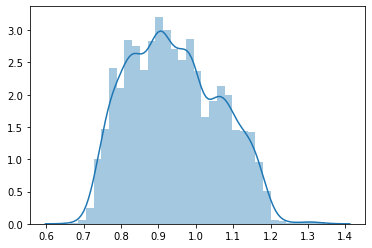

In [ ]:
import seaborn as sns

sns.distplot(data_features[:,0])

In [ ]:
### WRITE YOUR CODE BETWEEN THESE LINES - START

# do your classical pre-processing here

# store your training and testing datasets to be input in the VQC optimizer in the "training_input" and 
# "testing_input" variables respectively. These variables will eb accessed whiile creating a VQC instance later.

four_features = []
nine_features = []
for i in range(len(data_features)):
  if(data_labels[i]==4):
    four_features.append(data_features[i])
  elif(data_labels[i]==9):
    nine_features.append(data_features[i])

train_size = 500
test_size = 50
dp_size_four = 5
dp_size_nine = 5

four_train = four_features[:train_size]
nine_train = nine_features[:train_size]
four_test = four_features[train_size + 1:train_size + test_size + 1]
nine_test = nine_features[train_size + 1:train_size + test_size + 1]

four_train = np.array(four_train)
nine_train = np.array(nine_train)


training_input = {'A':four_train, 'B':nine_train}
testing_input =  {'A':four_test, 'B':nine_test}

# datapoints is our validation set
datapoints = []
dp_four = four_features[train_size + test_size + 2:train_size + test_size + 2 + dp_size_four]
dp_nine = nine_features[train_size + test_size + 2:train_size + test_size + 2 + dp_size_nine]
datapoints.append(np.concatenate((dp_four, dp_nine)))
dp_y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
datapoints.append(dp_y)

class_to_label = {'A': 0, 'B': 1}

### WRITE YOUR CODE BETWEEN THESE LINES - END

## Building a Quantum Feature Map

Given below is the `feature_map()` function. It takes no input and has to return a feature map which is either a `FeatureMap` or `QuantumCircuit` object. In the previous notebook you've learnt how feature maps work and the process of using existing feature maps in Qiskit or creating your own. In the space given **inside the function** you have to create a feature map and return it.   


**IMPORTANT:** 
* If you require Qiskit import statements other than the ones provided in the cell below, please include them inside the appropriate space provided. **All additional import statements must be Qiskit imports.** 
* the first line of the cell below must be `%%write_and_run feature_map.py`. This function stores the content of the cell below in the file `feature_map.py`

In [ ]:
%%write_and_run feature_map.py
# the write_and_run function writes the content in this cell into the file "feature_map.py"

### WRITE YOUR CODE BETWEEN THESE LINES - START
    
# import libraries that are used in the function below.
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap

### WRITE YOUR CODE BETWEEN THESE LINES - END

def feature_map(): 
    # BUILD FEATURE MAP HERE - START
    
    # import required qiskit libraries if additional libraries are required
    feature_dim = 3
    # build the feature map
    # feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, data_map_func=custom_data_map_func)
    feature_map = PauliFeatureMap(feature_dimension=feature_dim, reps=4, paulis = ['Z','Y','XY','ZZ'])
    
    # BUILD FEATURE MAP HERE - END
    
    #return the feature map which is either a FeatureMap or QuantumCircuit object
    return feature_map

In [ ]:
feature_map().draw()

┌───┐          »
q_0: ┤ H ├──■───────»
     ├───┤┌─┴─┐     »
q_1: ┤ H ├┤ X ├──■──»
     ├───┤└───┘┌─┴─┐»
q_2: ┤ H ├─────┤ X ├»
     └───┘     └───┘»
«                                                                                              »
«q_0: ─────────────────────────────────────────────────────────────────────────────────────────»
«                                                                                              »
«q_1: ─────────────────────────────────────────────────────────────────────────────────────────»
«     ┌───────────────────────────────────────────────────────────────────────────────────────┐»
«q_2: ┤ U1(2.0*(3.14159265358979 - x[0])*(3.14159265358979 - x[1])*(3.14159265358979 - x[2])) ├»
«     └───────────────────────────────────────────────────────────────────────────────────────┘»
«               ┌───┐          »
«q_0: ───────■──┤ H ├──■───────»
«          ┌─┴─┐├───┤┌─┴─┐     »
«q_1: ──■──┤ X ├┤ H ├┤ X ├──■──»
«     ┌─┴─┐├───┤└───┘└───┘┌─┴─┐»
«q_2: ┤ X ├┤ H ├──────────┤ X ├»
«     └───┘└───┘          └───┘»
«                                                                                              »
«q_0: ─────────────────────────────────────────────────────────────────────────────────────────»
«                                                                                              »
«q_1: ─────────────────────────────────────────────────────────────────────────────────────────»
«     ┌───────────────────────────────────────────────────────────────────────────────────────┐»
«q_2: ┤ U1(2.0*(3.14159265358979 - x[0])*(3.14159265358979 - x[1])*(3.14159265358979 - x[2])) ├»
«     └───────────────────────────────────────────────────────────────────────────────────────┘»
«               ┌───┐          »
«q_0: ───────■──┤ H ├──■───────»
«          ┌─┴─┐├───┤┌─┴─┐     »
«q_1: ──■──┤ X ├┤ H ├┤ X ├──■──»
«     ┌─┴─┐├───┤└───┘└───┘┌─┴─┐»
«q_2: ┤ X ├┤ H ├──────────┤ X ├»
«     └───┘└───┘          └───┘»
«                                                                                              »
«q_0: ─────────────────────────────────────────────────────────────────────────────────────────»
«                                                                                              »
«q_1: ─────────────────────────────────────────────────────────────────────────────────────────»
«     ┌───────────────────────────────────────────────────────────────────────────────────────┐»
«q_2: ┤ U1(2.0*(3.14159265358979 - x[0])*(3.14159265358979 - x[1])*(3.14159265358979 - x[2])) ├»
«     └───────────────────────────────────────────────────────────────────────────────────────┘»
«               
«q_0: ───────■──
«          ┌─┴─┐
«q_1: ──■──┤ X ├
«     ┌─┴─┐└───┘
«q_2: ┤ X ├─────
«     └───┘

## Building a Variational Circuit

Given below is the `variational_circuit()` function. It takes no input and has to return a variational circuit which is either a `VariationalForm` or `QuantumCircuit` object. In the previous notebook you've learnt how variational circuits work and the process of using existing variational circuit in Qiskit or creating your own. You have to create a variational circuit in the space given **inside the function** and return it. You can find various variational circuits in the [Qiskit Circuit Library](https://qiskit.org/documentation/apidoc/circuit_library.html) under N-local circuits.

**IMPORTANT:** 
* If you require Qiskit import statements other than the ones provided in the cell below, please include them inside the appropriate space provided. **All additional import statements must be Qiskit imports.** 
* the first line of the cell below must be `%%write_and_run feature_map.py`. This function stores the content of the cell below in the file `variational_circuit.py`

In [ ]:
%%write_and_run variational_circuit.py
# the write_and_run function writes the content in this cell into the file "variational_circuit.py"

### WRITE YOUR CODE BETWEEN THESE LINES - START
    
# import libraries that are used in the function below.
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import  RealAmplitudes, EfficientSU2
    
### WRITE YOUR CODE BETWEEN THESE LINES - END

def variational_circuit():
    # BUILD VARIATIONAL CIRCUIT HERE - START
    
    # import required qiskit libraries if additional libraries are required
    feature_dim = 3
    # build the variational circuit
    var_circuit = EfficientSU2(feature_dim, reps=2)

    # BUILD VARIATIONAL CIRCUIT HERE - END
    
    # return the variational circuit which is either a VaritionalForm or QuantumCircuit object
    return var_circuit

## Choosing a Classical Optimizer

In the `classical_optimizer()` function given below you will have to import the optimizer of your choice from [`qiskit.aqua.optimizers`](https://qiskit.org/documentation/apidoc/qiskit.aqua.components.optimizers.html) and return it. This function will not be called by the grading function `grade()` and thus the name of the function `classical_optimizer()`can be changed if needed. 

In [ ]:


def classical_optimizer():
    # CHOOSE AND RETURN CLASSICAL OPTIMIZER OBJECT - START
    
    # import the required clasical optimizer from qiskit.aqua.optimizers
    from qiskit.aqua.components.optimizers import COBYLA
    # create an optimizer object
    cls_opt = COBYLA(maxiter=500, tol=0.001)
    
    # CHOOSE AND RETURN CLASSICAL OPTIMIZER OBJECT - END
    return cls_opt

### Callback Function

The `VQC` class can take in a callback function to which the following parameters will be passed after every optimization cycle of the algorithm:

* `eval_count` : the evaulation counter
* `var_params` : value of parameters of the variational circuit
* `eval_val`  : current cross entropy cost 
* `index` : the batch index

In [ ]:
def call_back_vqc(eval_count, var_params, eval_val, index):
    print("eval_count: {}".format(eval_count))
    print("var_params: {}".format(var_params))
    print("eval_val: {}".format(eval_val))
    print("index: {}".format(index))

## Optimization Step

This is where the whole VQC algorithm will come together. First we create an instance of the `VQC` class. 

In [ ]:
# a fixed seed so that we get the same answer when the same input is given. 
seed = 10598

from qiskit.providers.aer import QasmSimulator
# setting our backend to qasm_simulator with the "statevector" method on. This particular setup is given as it was 
# found to perform better than most. Feel free to play around with different backend options.
backend = Aer.get_backend('qasm_simulator')
backend_options = {"method": "statevector"}

# creating a quantum instance using the backend and backend options taken before
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed, 
                                   backend_options=backend_options)

# creating a VQC instance which you will be used for training. Make sure you input the correct training_dataset and 
# testing_dataset as defined in your program.
vqc = VQC(optimizer=classical_optimizer(), 
          feature_map=feature_map(), 
          var_form=variational_circuit(), 
          callback=call_back_vqc, 
          training_dataset=training_input,     # training_input must be initialized with your training dataset
          test_dataset=testing_input)             # testing_input must be initialized with your testing dataset

Now, let's run the VQC classification routine

In [ ]:
start = time.process_time()

result = vqc.run(quantum_instance)

print("time taken: ")
print(time.process_time() - start)

print("testing success ratio: {}".format(result['testing_accuracy']))

eval_count: 0
var_params: [ 1.33748988  0.51374401  2.10906038 -1.90282209  1.01834873  0.68092393
  0.6220281   1.13346778  2.35620705 -0.06581489  0.79796489  0.20676595
  0.39386598 -0.54605258 -0.93954276 -0.47664358  0.10630246 -0.47958378]
eval_val: 0.8080830002937445
index: 0
eval_count: 1
var_params: [ 2.33748988  0.51374401  2.10906038 -1.90282209  1.01834873  0.68092393
  0.6220281   1.13346778  2.35620705 -0.06581489  0.79796489  0.20676595
  0.39386598 -0.54605258 -0.93954276 -0.47664358  0.10630246 -0.47958378]
eval_val: 0.8231919598954074
index: 1
eval_count: 2
var_params: [ 1.33748988  1.51374401  2.10906038 -1.90282209  1.01834873  0.68092393
  0.6220281   1.13346778  2.35620705 -0.06581489  0.79796489  0.20676595
  0.39386598 -0.54605258 -0.93954276 -0.47664358  0.10630246 -0.47958378]
eval_val: 0.915950353534913
index: 2
eval_count: 3
var_params: [ 1.33748988  0.51374401  3.10906038 -1.90282209  1.01834873  0.68092393
  0.6220281   1.13346778  2.35620705 -0.06581489  

## Storing the optimal parameters for grading

Once the training step of the vqc algorithm is done we obtain the optimal parameters for our specific variational form. For the grading function to be able to access these optimal parameters you will need to follow the steps below. 

* **Step 1**: Run the cell below with `print(repr(vqc.optimal_params))`. 
* **Step 2**: Copy the matrix of optimal parameters and store it in the variable `optimal_parameters` inside the function `return_optimal_params()` in the next cell. This will enable us to extract it while calculating the accuracy your the model during grading. Given below is a pictographical explanation of the same:  

<img src="https://s3-ap-southeast-1.amazonaws.com/he-public-data/opt_params456b075.png" width="800">

In [ ]:
print(repr(vqc.optimal_params))

array([ 0.19183812,  2.15837742, -0.62298602,  0.76618807, -0.67389646,
        0.36630465, -0.47874197, -2.59923093, -0.47347669, -2.3184435 ,
        0.40882897,  0.77837609,  0.65141567,  0.8677732 ,  1.01348783,
        2.12123496, -0.11971525,  0.30627551, -1.30127658, -1.40409949,
        1.3998857 , -0.9045788 , -0.07263081, -0.76367877, -0.67687187,
       -0.05686539,  0.41731061, -0.44914548,  0.24478931,  0.25420785])


In [ ]:
%%write_and_run optimal_params.py
# # the write_and_run function writes the content in this cell into the file "optimal_params.py"

### WRITE YOUR CODE BETWEEN THESE LINES - START
    
# import libraries that are used in the function below.
import numpy as np
    
### WRITE YOUR CODE BETWEEN THESE LINES - END

def return_optimal_params():
    # STORE THE OPTIMAL PARAMETERS AS AN ARRAY IN THE VARIABLE optimal_parameters 
    
    optimal_parameters = [ 0.19183812,  2.15837742, -0.62298602,  0.76618807, -0.67389646,
        0.36630465, -0.47874197, -2.59923093, -0.47347669, -2.3184435 ,
        0.40882897,  0.77837609,  0.65141567,  0.8677732 ,  1.01348783,
        2.12123496, -0.11971525,  0.30627551, -1.30127658, -1.40409949,
        1.3998857 , -0.9045788 , -0.07263081, -0.76367877, -0.67687187,
       -0.05686539,  0.41731061, -0.44914548,  0.24478931,  0.25420785]
    
    # STORE THE OPTIMAL PARAMETERS AS AN ARRAY IN THE VARIABLE optimal_parameters 
    return np.array(optimal_parameters)

## Submission

Before we go any further, check that you have the three files `feature_map.py`, `variational_circuit.py` and `optimal_params.py` in the **same working directory as this notebook**. If you do not, then go back to the start and run the notebook making sure you have filled in the code where its required. When you run the cell below, all the three files `feature_map.py`, `variational_circuit.py` and `optimal_params.py` are combined into one file named **"answer.py"**. Now your working directory will have four python (.py) files out of which **"answer.py"** is the submission file: 
* `answer.py` <- upload this file onto HackerEarth and click on "Submit and Evaluate"
* `feature_map.py`
* `variational_circuit.py`
* `optimal_params.py`

In [ ]:
solution = ['feature_map.py','variational_circuit.py','optimal_params.py']
file = open("answer.py","w")
file.truncate(0)
for i in solution:    
    with open(i) as f:
        with open("answer.py", "a") as f1:
            for line in f:
                f1.write(line)
file.close()

## Grading Function

Given below is the grading function that we shall use to grade your submission with a test dataset that is of the same format as `challenge_dataset_4_9.csv`. You can use it to grade your submission by extracting a few points out of the `challenge_dataset_4_9.csv` to get a basic idea of how your model is performing. 

In [ ]:
#imports required for the grading function 
from qiskit import *
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQC
from qiskit.aqua.components.feature_maps import FeatureMap
from qiskit.aqua.components.variational_forms import VariationalForm
import numpy as np

### Working of the grading function

The grading function `grade()` takes as **input**: 

* `test_data`: (`np.ndarray`) -- **no. of datapoints $\times$ dimension of data** : the datapoints against which we want to test our model. 


* `test_labels`: (`np.ndarray`) -- **no. of datapoints $\times$ 1** : A column vector with each entry either 0 or 1 as entries.


* `feature_map`: (`QuantumCircuit` or `FeatureMap`) -- A quantum feature map which is the output of `feature_map()` defined earlier.


* `variational_form`: (`QuantumCircuit` or `VariationalForm`) -- A variational form which is the output of `variational_circuit()` defined earlier.


* `optimal_params`: (`numpy.ndarray`) -- the optimal parameters obtained after running the VQC algorithm above. These are the values obtained when the function `return_optimal_params()` is run. 


* `find_circuit_cost` : (`bool`) -- Calculates the circuit cost if set to `True`. Circuit cost is calculated by converting the circuit to the basis gate set `\[ 'u3', 'cx'\]` and then applying the formula **cost = 1$\times$(no.of u3 gates) + 10$\times$(no.of cx gates)**.


* `verbose` : (`bool`) -- prints the result message if set to `True`.

And gives as **output**: 

* `model_accuracy` : (`numpy.float64`) -- percent accuracy of the model. 


* `circuit_cost`: (`int`) -- circuit cost as explained above.


* `ans`: (`tuple`) -- Output of the `VQC.predict()` method. 


* `result_msg`: (`str`) -- Result message which also outputs the error message in case of one.


* `unrolled_circuit`: (`QuantumCircuit` or `None`) -- the circuit obtained after unrolling the full VQC circuit and substituting the optimal parameters to the basis gate set `\[ 'u3', 'cx'\]`.

**Note:** if you look inside the `grade()` function in Section 2 you'll see that we have initialized a COBYLA optimizer though the prediction step will not require one. Similarily we have given a dataset to `training dataset`. Both of these are dummy variables. The reason for this is because these are not optional variables the `VQC` class instantiation.  

In [ ]:
def grade(test_data, test_labels, feature_map, variational_form, optimal_params, find_circuit_cost=True, verbose=True):
    seed = 10598
    model_accuracy = None 
    circuit_cost=None 
    ans = None
    unrolled_circuit = None
    result_msg=''
    data_dim = np.array(test_data).shape[1]
    dataset_size = np.array(test_data).shape[0]
    dummy_training_dataset=training_input = {'A':np.ones((2,data_dim)), 'B':np.ones((2, data_dim))}
    
    # converting 4's to 0's and 9's to 1's for checking 
    test_labels_transformed = np.where(test_labels==4, 0., 1.)
    max_qubit_count = 6
    max_circuit_cost = 2000
    
    # Section 1
    if feature_map is None:
        result_msg += 'feature_map variable is None. Please submit a valid entry' if verbose else ''
    elif variational_form is None: 
        result_msg += 'variational_form variable is None. Please submit a valid entry' if verbose else ''
    elif optimal_params is None: 
        result_msg += 'optimal_params variable is None. Please submit a valid entry' if verbose else ''
    elif test_data is None: 
        result_msg += 'test_data variable is None. Please submit a valid entry' if verbose else ''
    elif test_labels is None: 
        result_msg += 'test_labels variable is None. Please submit a valid entry' if verbose else ''
    elif not isinstance(feature_map, (QuantumCircuit, FeatureMap)):
        result_msg += 'feature_map variable should be a QuantumCircuit or a FeatureMap not (%s)' % \
                      type(feature_map) if verbose else ''
    elif not isinstance(variational_form, (QuantumCircuit, VariationalForm)):
        result_msg += 'variational_form variable should be a QuantumCircuit or a VariationalForm not (%s)' % \
                      type(variational_form) if verbose else ''
    elif not isinstance(test_data, np.ndarray):
        result_msg += 'test_data variable should be a numpy.ndarray not (%s)' % \
                      type(test_data) if verbose else ''
    elif not isinstance(test_labels, np.ndarray):
        result_msg += 'test_labels variable should be a numpy.ndarray not (%s)' % \
                      type(test_labels) if verbose else ''
    elif not isinstance(optimal_params, np.ndarray):
        result_msg += 'optimal_params variable should be a numpy.ndarray not (%s)' % \
                      type(optimal_params) if verbose else ''
    elif not dataset_size == test_labels_transformed.shape[0]:
        result_msg += 'Dataset size and label array size must be equal'
    # Section 2
    else:
        
        # setting up COBYLA optimizer as a dummy optimizer
        from qiskit.aqua.components.optimizers import COBYLA
        dummy_optimizer = COBYLA()

        # setting up the backend and creating a quantum instance
        backend = Aer.get_backend('qasm_simulator')
        backend_options = {"method": "statevector"}
        quantum_instance = QuantumInstance(backend, 
                                           shots=2000, 
                                           seed_simulator=seed, 
                                           seed_transpiler=seed, 
                                           backend_options=backend_options)

        # creating a VQC instance and running the VQC.predict method to get the accuracy of the model 
        vqc = VQC(optimizer=dummy_optimizer, 
                  feature_map=feature_map, 
                  var_form=variational_form, 
                  training_dataset=dummy_training_dataset)
        
        from qiskit.transpiler import PassManager
        from qiskit.transpiler.passes import Unroller
        pass_ = Unroller(['u3', 'cx'])
        pm = PassManager(pass_)
        # construct circuit with first datapoint
        circuit = vqc.construct_circuit(data[0], optimal_params)
        unrolled_circuit = pm.run(circuit)
        gates = unrolled_circuit.count_ops()
        if 'u3' in gates: 
            circuit_cost = gates['u3']
        if 'cx' in gates: 
            circuit_cost+= 10*gates['cx']
        
        if circuit.num_qubits > max_qubit_count:
            result_msg += 'Your quantum circuit is using more than 6 qubits. Reduce the number of qubits used and try again.'
        elif circuit_cost > max_circuit_cost:
            result_msg += 'The cost of your circuit is exceeding the maximum accpetable cost of 2000. Reduce the circuit cost and try again.'
        else: 
            
            ans = vqc.predict(test_data, quantum_instance=quantum_instance, params=np.array(optimal_params))
            model_accuracy = np.sum(np.equal(test_labels_transformed, ans[1]))/len(ans[1])

            result_msg += 'Accuracy of the model is {}'.format(model_accuracy) if verbose else ''
            result_msg += ' and circuit cost is {}'.format(circuit_cost) if verbose else ''
            
    return model_accuracy, circuit_cost, ans, result_msg, unrolled_circuit

## Process of grading using a dummy grading dataset

Let us create a dummy grading dataset with features and labels `grading_features` and `grading_labels` created from the last 2000 datapoints from `data_features` and `data_labels`so that we can a rough estimate of our accuaracy. It must be noted that this may not be a balanced dataset, i.e, may not have equal number of `4`'s and `9`'s and is not best practice. This is only given for the purpose of the demo of `grade()` function. In the final scoring done on HackerEarth, the testing dataset used will have a balanced number of class labels `4` and `9`.

In [ ]:
grading_dataset_size=2000    # this value is not per digit but in total
grading_features = data_features[-grading_dataset_size:]
grading_labels = data_labels[-grading_dataset_size:]

In [ ]:
start = time.process_time()

accuracy, circuit_cost, ans, result_msg, full_circuit  =  grade(test_data=grading_features, 
                                                                test_labels=grading_labels, 
                                                                feature_map=feature_map(), 
                                                                variational_form=variational_circuit(), 
                                                                optimal_params=return_optimal_params())

print("time taken: {} seconds".format(time.process_time() - start))
print(result_msg)

time taken: 88.84131615799993 seconds
Accuracy of the model is 0.79 and circuit cost is 762


You can also check your **accuracy**, **circuit_cost** and **full_circuit** which is the result of combining the feature map and variational circuit and unrolling into the basis \['u3', 'cx'\].

In [ ]:
print("Accuracy of the model: {}".format(accuracy))
print("Circuit Cost: {}".format(circuit_cost))
print("The complete unrolled circuit: ")
full_circuit.draw()

Accuracy of the model: 0.79
Circuit Cost: 762
The complete unrolled circuit: 


┌───────────────┐  ┌───────────┐   ┌─────────────────────┐»
q_0: ┤ U3(pi/2,0,pi) ├──┤ U3(0,0,8) ├───┤ U3(pi/2,-pi/2,pi/2) ├»
     ├───────────────┤┌─┴───────────┴──┐├─────────────────────┤»
q_1: ┤ U3(pi/2,0,pi) ├┤ U3(0,0,1.6456) ├┤ U3(pi/2,-pi/2,pi/2) ├»
     ├───────────────┤├────────────────┤├─────────────────────┤»
q_2: ┤ U3(pi/2,0,pi) ├┤ U3(0,0,1.8033) ├┤ U3(pi/2,-pi/2,pi/2) ├»
     └───────────────┘└────────────────┘└─────────────────────┘»
c_0: ══════════════════════════════════════════════════════════»
                                                               »
c_1: ══════════════════════════════════════════════════════════»
                                                               »
c_2: ══════════════════════════════════════════════════════════»
                                                               »
«       ┌───────────┐   ┌──────────────────────┐┌─────────────────────┐     »
«q_0: ──┤ U3(0,0,8) ├───┤ U3(-pi/2,-pi/2,pi/2) ├┤ U3(pi/2,-pi/2,pi/2) ├──■──»
«     ┌─┴───────────┴──┐├──────────────────────┤└──┬───────────────┬──┘┌─┴─┐»
«q_1: ┤ U3(0,0,1.6456) ├┤ U3(-pi/2,-pi/2,pi/2) ├───┤ U3(pi/2,0,pi) ├───┤ X ├»
«     ├────────────────┤├──────────────────────┤   ├───────────────┤   └───┘»
«q_2: ┤ U3(0,0,1.8033) ├┤ U3(-pi/2,-pi/2,pi/2) ├───┤ U3(pi/2,0,pi) ├────────»
«     └────────────────┘└──────────────────────┘   └───────────────┘        »
«c_0: ══════════════════════════════════════════════════════════════════════»
«                                                                           »
«c_1: ══════════════════════════════════════════════════════════════════════»
«                                                                           »
«c_2: ══════════════════════════════════════════════════════════════════════»
«                                                                           »
«                             ┌──────────────────────┐┌─────────────────────┐»
«q_0: ─────────────────────■──┤ U3(-pi/2,-pi/2,pi/2) ├┤ U3(pi/2,-pi/2,pi/2) ├»
«     ┌─────────────────┐┌─┴─┐└──┬───────────────┬───┘├─────────────────────┤»
«q_1: ┤ U3(0,0,-3.9809) ├┤ X ├───┤ U3(pi/2,0,pi) ├────┤ U3(pi/2,-pi/2,pi/2) ├»
«     └─────────────────┘└───┘   └───────────────┘    └─────────────────────┘»
«q_2: ───────────────────────────────────────────────────────────────────────»
«                                                                            »
«c_0: ═══════════════════════════════════════════════════════════════════════»
«                                                                            »
«c_1: ═══════════════════════════════════════════════════════════════════════»
«                                                                            »
«c_2: ═══════════════════════════════════════════════════════════════════════»
«                                                                            »
«                                  ┌──────────────────────┐                 »
«q_0: ──■───────────────────────■──┤ U3(-pi/2,-pi/2,pi/2) ├─────────────────»
«       │                       │  └──────────────────────┘                 »
«q_1: ──┼───────────────────────┼───────────────────────────────────────────»
«     ┌─┴─┐┌─────────────────┐┌─┴─┐   ┌───────────────┐    ┌───────────────┐»
«q_2: ┤ X ├┤ U3(0,0,-3.8456) ├┤ X ├───┤ U3(pi/2,0,pi) ├────┤ U3(pi/2,0,pi) ├»
«     └───┘└─────────────────┘└───┘   └───────────────┘    └───────────────┘»
«c_0: ══════════════════════════════════════════════════════════════════════»
«                                                                           »
«c_1: ══════════════════════════════════════════════════════════════════════»
«                                                                           »
«c_2: ══════════════════════════════════════════════════════════════════════»
«                                                                           »
«                                                              »
«q_0: ──────────────────────────────────